In [ ]:
import os
import cv2
import torch
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import timm
from torchvision import transforms

drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/CircuitGuard_Project/models/circuitguard_efficientnet_b4_v2.pth"
DATA_ZIP = "/content/drive/MyDrive/CircuitGuard_Project/defect_crops_final.zip"
OUTPUT_DIR = "/content/module4_evaluation"
ANNOTATED_DIR = os.path.join(OUTPUT_DIR, "annotated_images")

os.makedirs(ANNOTATED_DIR, exist_ok=True)
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {DEVICE}")

if not os.path.exists("/content/defect_crops_final") and not os.path.exists("/content/content/defect_crops_final"):
    print("📂 Unzipping Test Data...")
    !unzip -q "{DATA_ZIP}" -d "/content/"

possible_roots = [
    "/content/defect_crops_final",
    "/content/content/defect_crops_final",
    "/content"
]

DATA_ROOT = None
for root in possible_roots:
    if os.path.exists(os.path.join(root, "Short")):
        DATA_ROOT = root
        break

if DATA_ROOT is None:
    print("❌ Error: Could not find image folders. Searching recursively...")
    for root, dirs, files in os.walk("/content"):
        if "Short" in dirs:
            DATA_ROOT = root
            break

if DATA_ROOT:
    print(f"✅ Dataset found at: {DATA_ROOT}")
else:
    raise FileNotFoundError("Could not locate the dataset folders (Short, Spur, etc).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Device: cuda
✅ Dataset found at: /content/content/defect_crops_final
🧠 Loading EfficientNet-B4...
✅ Model Loaded.

🚀 Starting Inference Pipeline...
📊 Test Set Size: 300 images


Running Inference: 100%|██████████| 300/300 [00:08<00:00, 35.48it/s]



FINAL EVALUATION REPORT
Total Tested: 300
Accuracy: 95.00%
--------------------------------------------------
                 precision    recall  f1-score   support

   Missing_hole       1.00      1.00      1.00        50
     Mouse_bite       0.84      0.96      0.90        50
   Open_circuit       0.98      0.92      0.95        50
          Short       0.94      1.00      0.97        50
           Spur       0.98      0.90      0.94        50
Spurious_copper       0.98      0.92      0.95        50

       accuracy                           0.95       300
      macro avg       0.95      0.95      0.95       300
   weighted avg       0.95      0.95      0.95       300



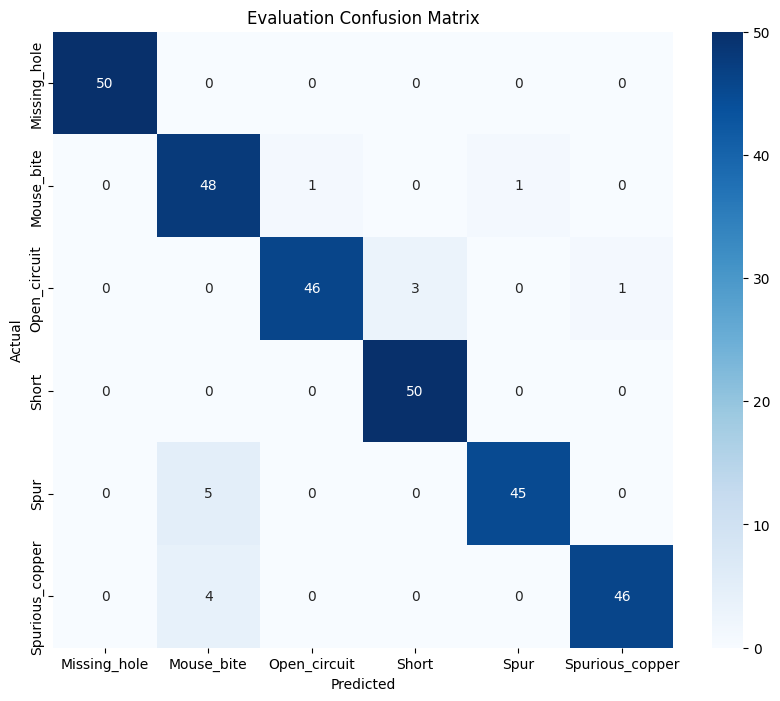


📦 Zipping Deliverables...
✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/module4_deliverables.zip


In [ ]:
print("🧠 Loading EfficientNet-B4...")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
classes = checkpoint['classes']
model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=len(classes))
model.load_state_dict(checkpoint['model'])
model.to(DEVICE)
model.eval()
print("✅ Model Loaded.")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# INFERENCE PIPELINE
print("\n🚀 Starting Inference Pipeline...")

test_samples = []
for cls in classes:
    cls_files = glob.glob(os.path.join(DATA_ROOT, cls, "*"))
    # Taking 50 random samples per class
    samples = random.sample(cls_files, min(len(cls_files), 50))
    for f in samples:
        test_samples.append({'path': f, 'true_label': cls})

print(f"📊 Test Set Size: {len(test_samples)} images")

if len(test_samples) == 0:
    raise ValueError("Test set is empty! Check the path logic.")

results = []

for sample in tqdm(test_samples, desc="Running Inference"):
    img_path = sample['path']
    true_label = sample['true_label']

    try:
        original_img = Image.open(img_path).convert('RGB')
        input_tensor = transform(original_img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probs, 1)

        pred_label = classes[pred_idx.item()]
        confidence = conf.item() * 100

        is_correct = (pred_label == true_label)

        img_cv = cv2.imread(img_path)
        if img_cv is not None:
            color = (0, 255, 0) if is_correct else (0, 0, 255)
            img_cv = cv2.resize(img_cv, (256, 256))
            cv2.rectangle(img_cv, (0,0), (256, 256), color, 4)
            cv2.putText(img_cv, f"Pred: {pred_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            cv2.putText(img_cv, f"Conf: {confidence:.1f}%", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            if not is_correct:
                cv2.putText(img_cv, f"True: {true_label}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            filename = os.path.basename(img_path)
            cv2.imwrite(os.path.join(ANNOTATED_DIR, f"{'OK' if is_correct else 'FAIL'}_{filename}"), img_cv)

        results.append({
            'filename': os.path.basename(img_path),
            'true_label': true_label,
            'pred_label': pred_label,
            'confidence': confidence,
            'match': is_correct
        })
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

if len(results) > 0:
    df = pd.DataFrame(results)
    csv_path = os.path.join(OUTPUT_DIR, "final_evaluation_report.csv")
    df.to_csv(csv_path, index=False)

    print("\n" + "="*50)
    print("FINAL EVALUATION REPORT")
    print("="*50)
    print(f"Total Tested: {len(df)}")
    print(f"Accuracy: {df['match'].mean() * 100:.2f}%")
    print("-" * 50)
    print(classification_report(df['true_label'], df['pred_label'], target_names=classes))

    cm = confusion_matrix(df['true_label'], df['pred_label'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title('Evaluation Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
    plt.show()

    print("\n📦 Zipping Deliverables...")
    !zip -q -r /content/module4_deliverables.zip {OUTPUT_DIR}
    !cp /content/module4_deliverables.zip /content/drive/MyDrive/CircuitGuard_Project/
    print(f"✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/module4_deliverables.zip")
else:
    print("❌ No results generated.")